In [3]:
from util.data import (
    load_combined_grammar_data,
    load_grammar_data_by_category,
    load_numerical_data,
)
from pprint import pprint
from module.head_select import head_select
from util.model import get_device_memory_report
from module.blocked_attention import load_altered_attention_model, get_model_dimensions, disable_head, enable_head, get_disabled_heads
from util.chat import (
    load_embeddings_dataset,
    load_embeddings_dataset_batch,
    load_llm_generations,
)
from util.model import load_model
from plot.layer_seperation import plot_all_layers_divergence
from random import shuffle
import torch
import json

ValueError: module functions cannot set METH_CLASS or METH_STATIC

In [2]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
get_device_memory_report(device)

Device: cuda:6 [NVIDIA RTX 6000 Ada Generation]
Free Memory: 46.96/47.38 GB [99.11%]


In [3]:
# llama_8B, llama_8B_tokenizer = load_model("meta-llama/Llama-3.1-8B-Instruct", device)
# llama_8B, llama_8B_tokenizer = load_model('google/gemma-2-9b-it', device)
llama_8B, llama_8B_tokenizer = load_altered_attention_model(
    "google/gemma-2-9b-it", device, model_type="gemma"
)

Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


In [4]:
n_layers, n_heads = get_model_dimensions(llama_8B, llama_8B_tokenizer, device)

to_disable = [i for i in range(int(n_layers * .15), int(n_layers * .25))]
print(to_disable)

# for layer in range(n_layers):
#     for head in range(n_heads):
#         enable_head(llama_8B, layer, head)

for layer in to_disable:
    for head in range(n_heads):
        disable_head(llama_8B, layer, head)
# for layer in to_disable:
#     for head in range(n_heads):

#         # if (layer, head) not in activated_numerical:
#         disable_head(llama_8B, layer, head)
pprint(get_disabled_heads(llama_8B))

[6, 7, 8, 9]
{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 7: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 8: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 9: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: [],
 30: [],
 31: [],
 32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: [],
 40: [],
 41: []}


In [25]:
numerical_data = load_numerical_data(margin=50)
shuffle(numerical_data)
numerical_data = numerical_data[:100]
numerical_gembeddings = load_embeddings_dataset(
    numerical_data,
    llama_8B,
    llama_8B_tokenizer,
    device,
    types_=["mcq", "bin", "raw"],
    use_tqdm=True,
    grammar=False,
    use_system_message=False,
)

1it [00:00,  1.45it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x785a2d9d56d0>>
Traceback (most recent call last):
  File "/scratch/f00561n/miniconda3/envs/thesis/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
66it [00:48,  1.32it/s]

In [6]:
grammar_data = load_grammar_data_by_category(
    category="linguistics_term", value="argument_structure", sample_rate=1
)
shuffle(grammar_data)
grammar_data = grammar_data[:100]
grammar_embeddings = load_embeddings_dataset(
    grammar_data,
    llama_8B,
    llama_8B_tokenizer,
    device,
    types_=["mcq", "bin", "raw"],
    use_tqdm=True,
    grammar=True,
    use_system_message=False,
)

100it [01:06,  1.50it/s]


In [7]:
pprint(numerical_data)

[{'bad': '9195 + 43 = 13857', 'good': '9195 + 43 = 9238'},
 {'bad': '20 + 6940 = 10440', 'good': '20 + 6940 = 6960'},
 {'bad': '22701 + 54765 = 116199', 'good': '22701 + 54765 = 77466'},
 {'bad': '42888 + 47107 = 134992', 'good': '42888 + 47107 = 89995'},
 {'bad': '614 + 222 = 418', 'good': '614 + 222 = 836'},
 {'bad': '879 + 4132 = 2505', 'good': '879 + 4132 = 5011'},
 {'bad': '62 + 17994 = 27084', 'good': '62 + 17994 = 18056'},
 {'bad': '258 + 3538 = 5694', 'good': '258 + 3538 = 3796'},
 {'bad': '64 + 2227 = 3436', 'good': '64 + 2227 = 2291'},
 {'bad': '1243 + 48 = 1936', 'good': '1243 + 48 = 1291'},
 {'bad': '25 + 558 = 874', 'good': '25 + 558 = 583'},
 {'bad': '776 + 394 = 1755', 'good': '776 + 394 = 1170'},
 {'bad': '20 + 86920 = 43470', 'good': '20 + 86920 = 86940'},
 {'bad': '56 + 8071 = 12190', 'good': '56 + 8071 = 8127'},
 {'bad': '57563 + 59 = 86433', 'good': '57563 + 59 = 57622'},
 {'bad': '47 + 45 = 46', 'good': '47 + 45 = 92'},
 {'bad': '57 + 711 = 384', 'good': '57 + 711 

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier


def plot_all_layers_divergence(
    embeddings, method="pca", divisions=[0, 0.25, 0.5, 0.75, 1]
):
    n_types, n_divisions = len(embeddings.keys()), len(divisions)
    fig, axs = plt.subplots(
        n_types, n_divisions, figsize=(n_divisions * 3, n_types * 3)
    )
    n_layers = len(list(embeddings.values())[0][0]["states"])
    layers_idx = np.array([int((n_layers - 1) * x) for x in divisions])
    layers_idx[0] += 1
    for i, type_ in enumerate(embeddings):

        states = np.array([x["states"] for x in embeddings[type_]])
        states = np.transpose(states, (1, 0, 2))[layers_idx]
        labels = np.array([int(x["answer"]) for x in embeddings[type_]])
        for j, layer_idx in enumerate(layers_idx):
            if method == "pca":
                pca = PCA(n_components=2)
                result = pca.fit_transform(states[j])
            elif method == "tsne":
                tsne = TSNE(n_components=2, random_state=42, perplexity=50)
                result = tsne.fit_transform(states[j])
            sns.scatterplot(
                x=result[:, 0],
                y=result[:, 1],
                hue=labels,
                palette=sns.color_palette("bright", len(np.unique(labels))),
                s=10,
                ax=axs[i, j],
            )
            if i == 0:
                axs[i, j].set_title(f"Layer {layer_idx}")
            if j == 0:
                axs[i, j].set_ylabel(type_)
    plt.tight_layout()
    plt.show()

def get_linear_separation(X, y):
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    svm = SVC(kernel="linear")
    svm.fit(result, y)
    return svm.score(result, y)

def get_mlp_separation(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    mlp = MLPClassifier(hidden_layer_sizes=(32, 32), max_iter=500)
    mlp.fit(X_train, y_train)
    return mlp.score(X_test, y_test)

def plot_all_layers_separation(embeddings, divisions=[0, 0.25, 0.5, 0.75, 1]):
    
    n_types, n_divisions = len(embeddings.keys()), len(divisions)
    fig, axs = plt.subplots(
        n_types, 1, figsize=(15, 10)
    )
    n_layers = len(list(embeddings.values())[0][0]["states"])
    layers_idx = np.array([int((n_layers - 1) * x) for x in divisions])

    for i, type_ in enumerate(embeddings):
        states = np.array([x["states"] for x in embeddings[type_]])
        states = np.transpose(states, (1, 0, 2))[layers_idx]
        labels = np.array([int(x["answer"]) for x in embeddings[type_]])

        linear_seperability, mlp_seperability = [], []
        for j, layer_idx in enumerate(layers_idx):
            X, y = states[j], labels
            linear_seperability.append(get_linear_separation(X, y))
            mlp_seperability.append(get_mlp_separation(X, y))

        axs[i].plot(divisions, linear_seperability, label="Linear SVM")
        axs[i].scatter(divisions, linear_seperability)
        axs[i].plot(divisions, mlp_seperability, label="MLP")
        axs[i].scatter(divisions, mlp_seperability)

        for j, layer_idx in enumerate(layers_idx):
            axs[i].text(divisions[j], linear_seperability[j], f"{linear_seperability[j]:.2f}", ha="center", va="bottom")
            axs[i].text(divisions[j], mlp_seperability[j], f"{mlp_seperability[j]:.2f}", ha="center", va="bottom")
        axs[i].set_title(type_)
        axs[i].legend()
        


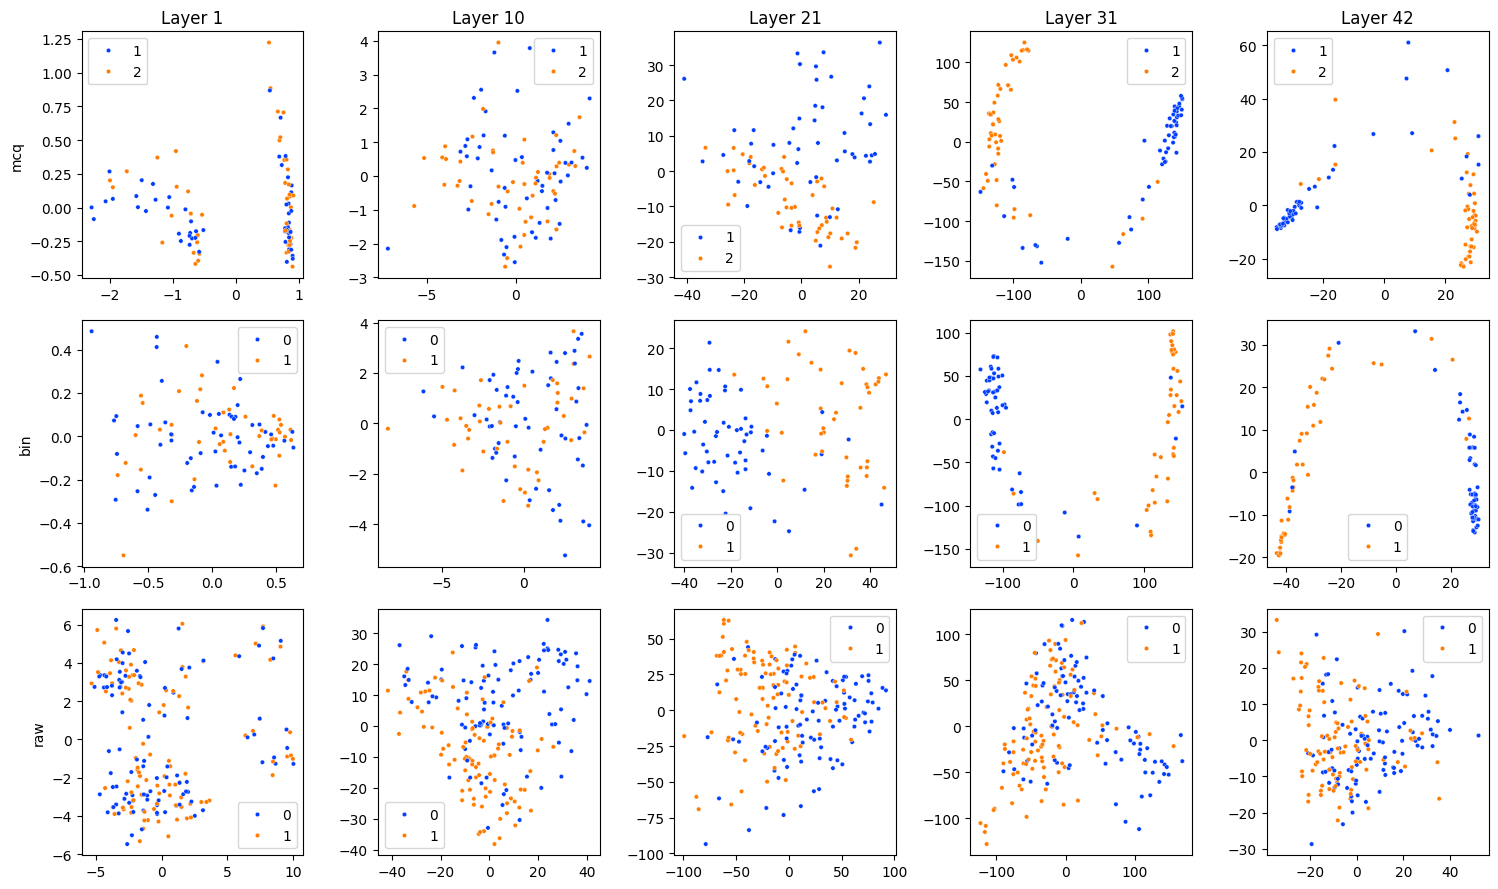

In [38]:
plot_all_layers_divergence(grammar_embeddings, method="pca")

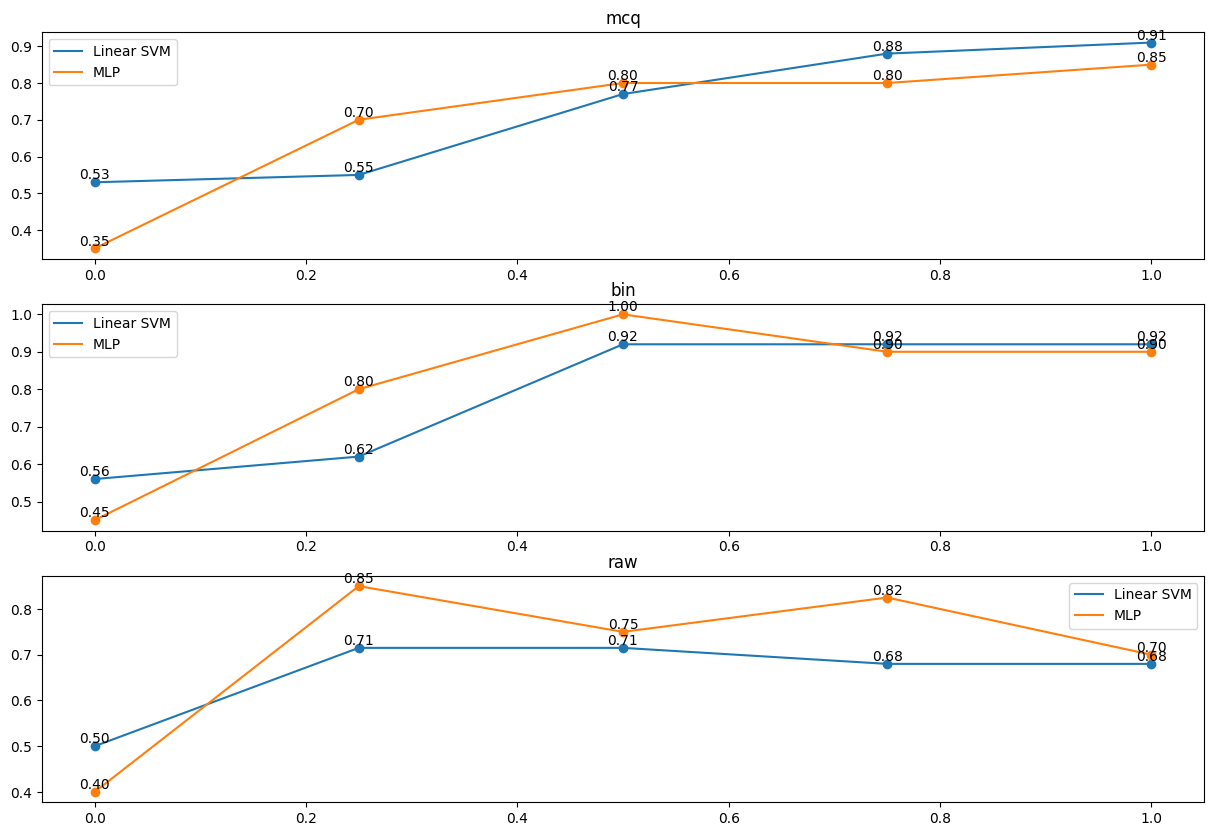

In [39]:
plot_all_layers_separation(grammar_embeddings)

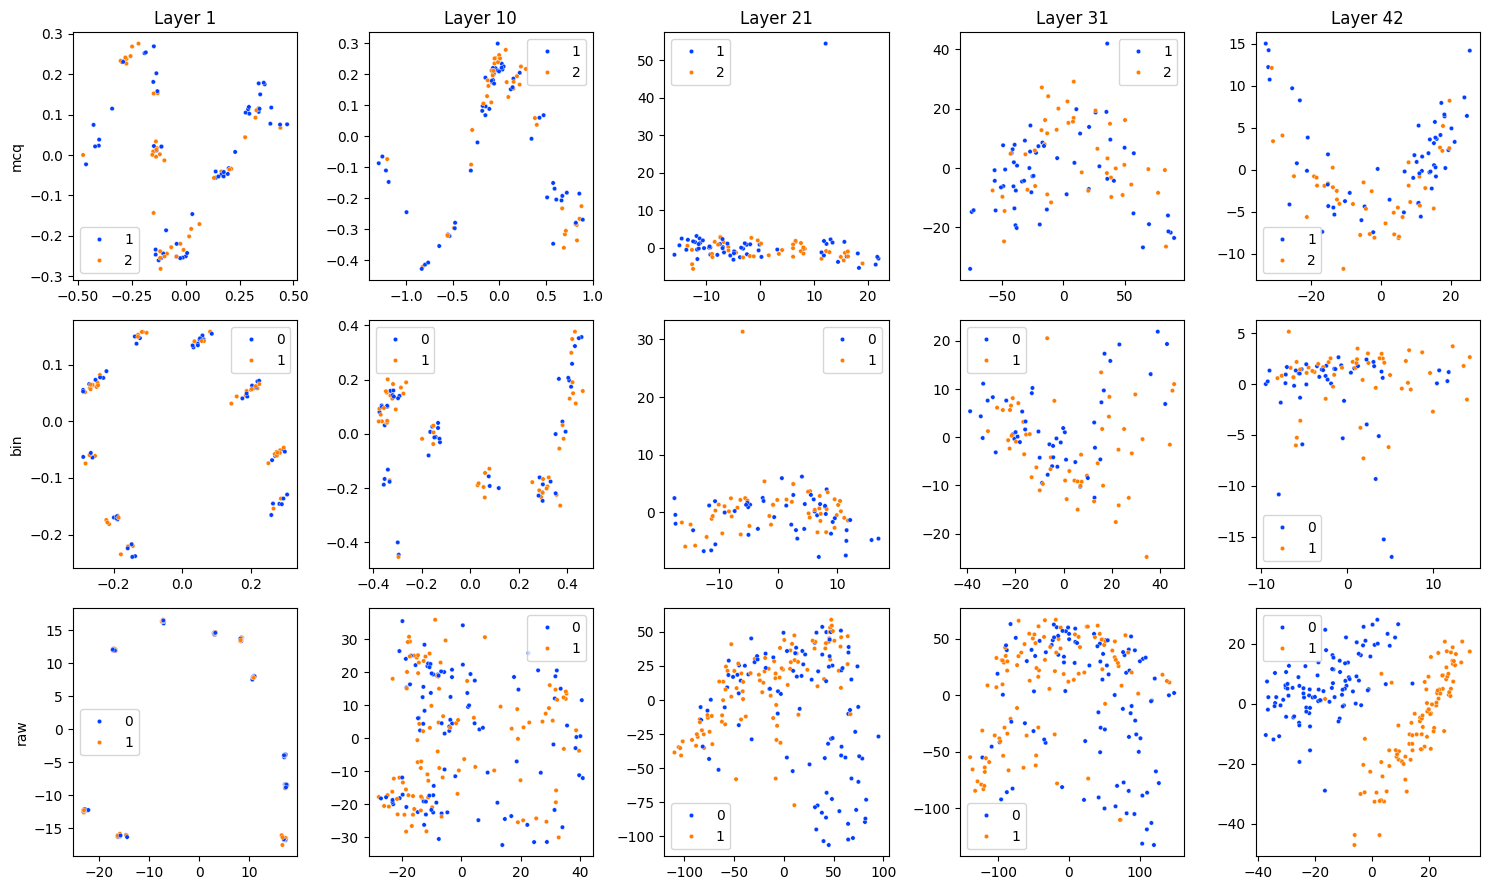

In [26]:
plot_all_layers_divergence(numerical_gembeddings, method="pca")

In [ ]:
plot_all_layers_separation(numerical_gembeddings)

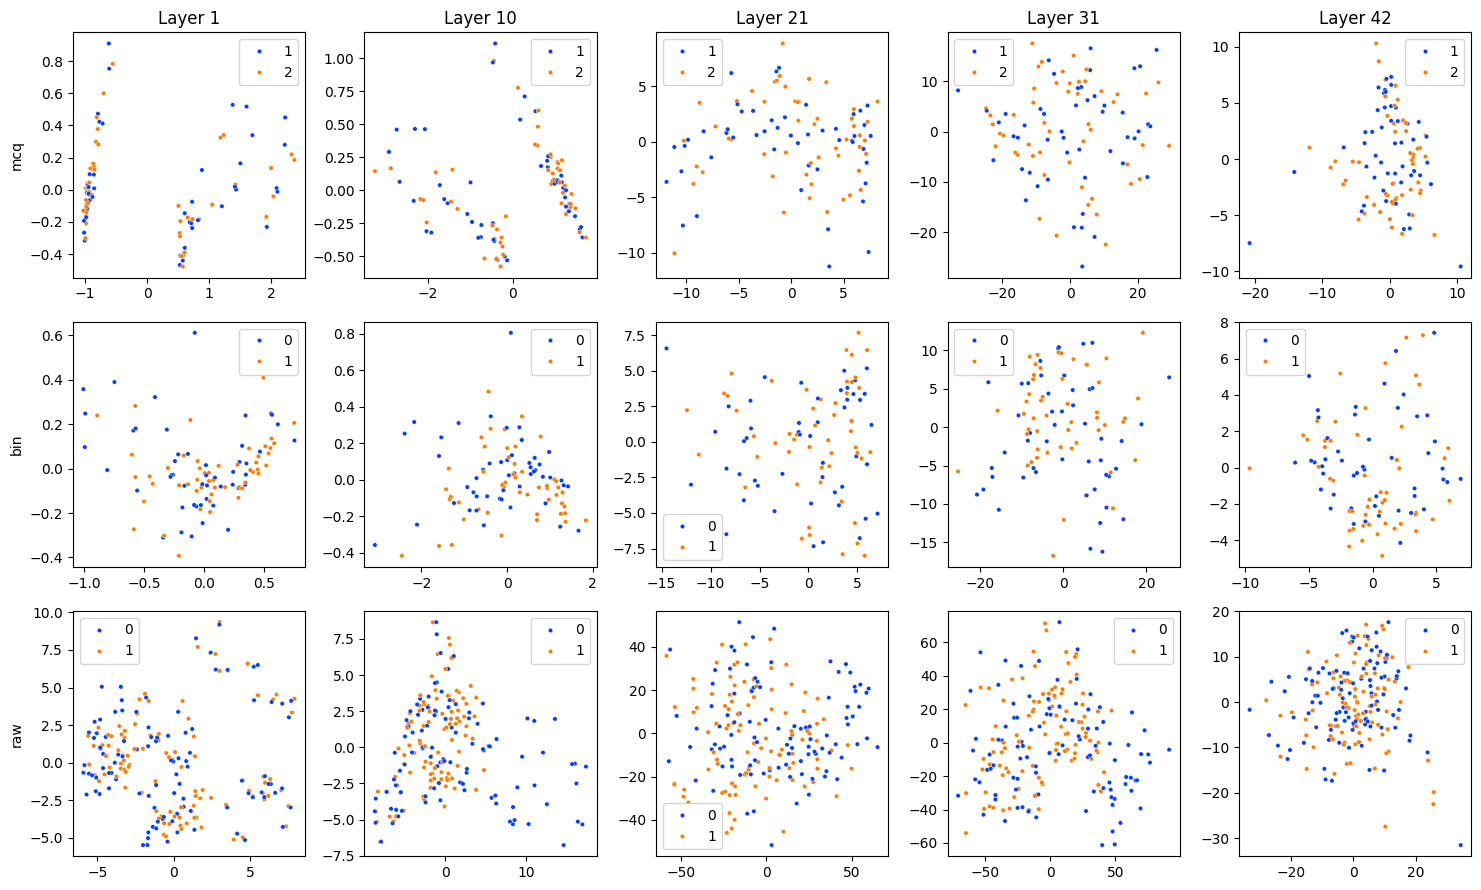

In [9]:
plot_all_layers_divergence(grammar_embeddings, method="pca")

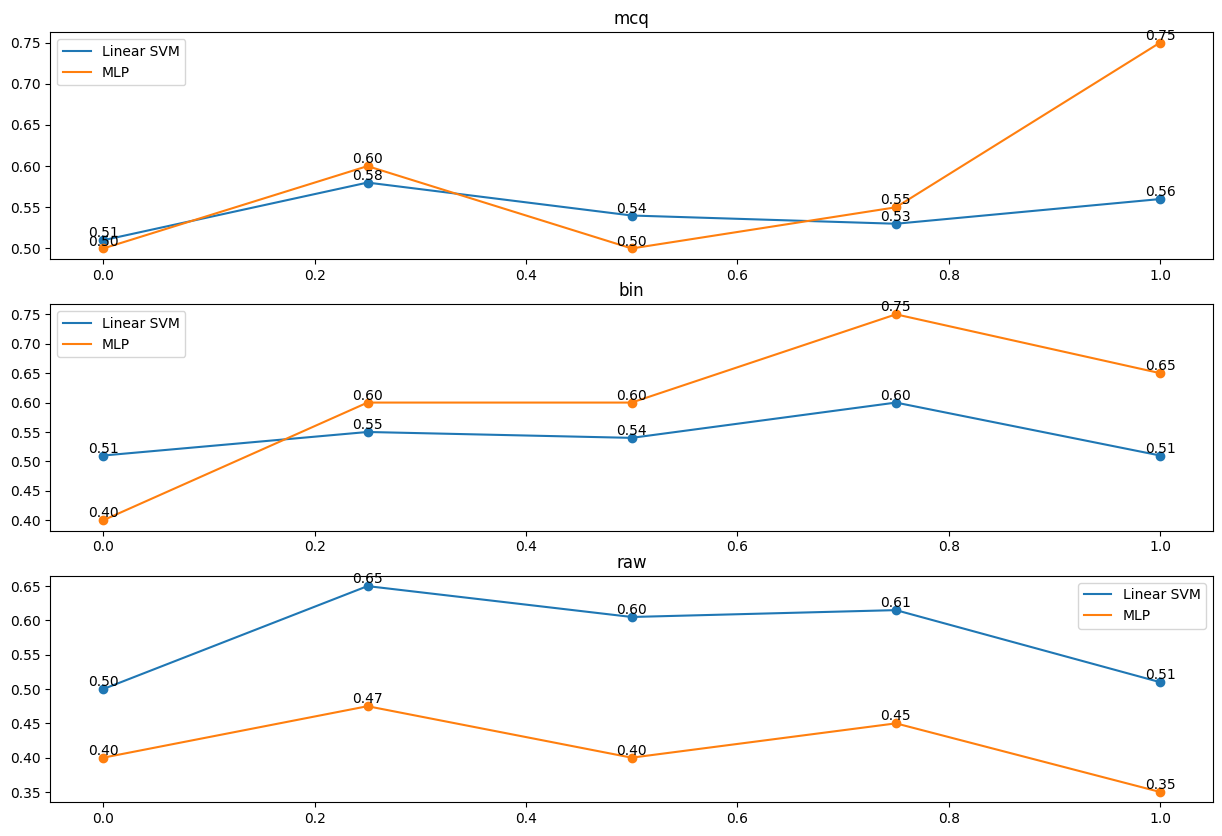

In [10]:
plot_all_layers_separation(grammar_embeddings)

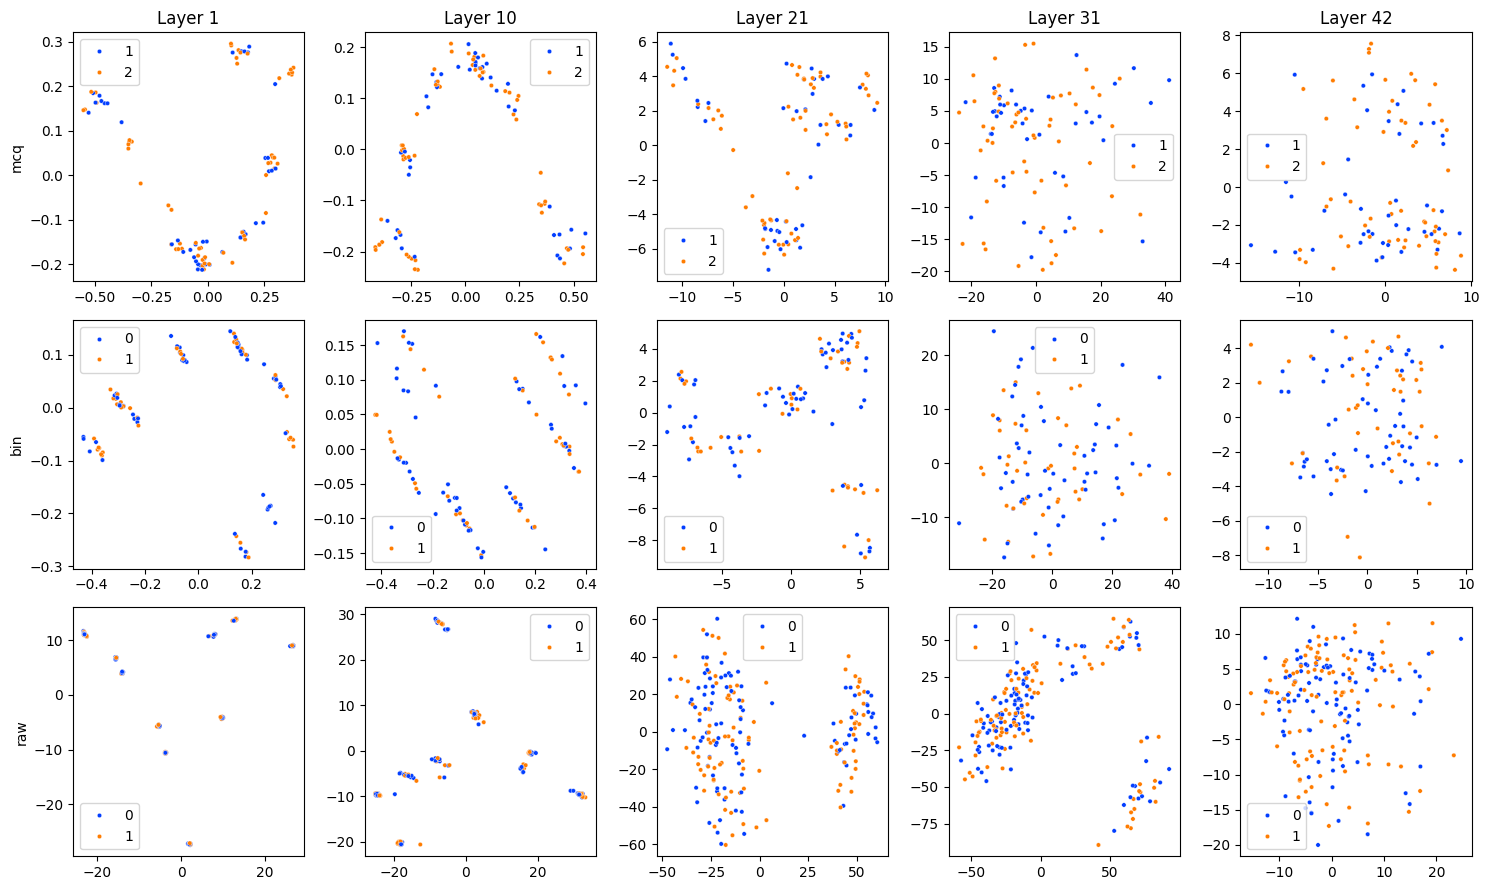

In [11]:
plot_all_layers_divergence(numerical_gembeddings, method="pca")

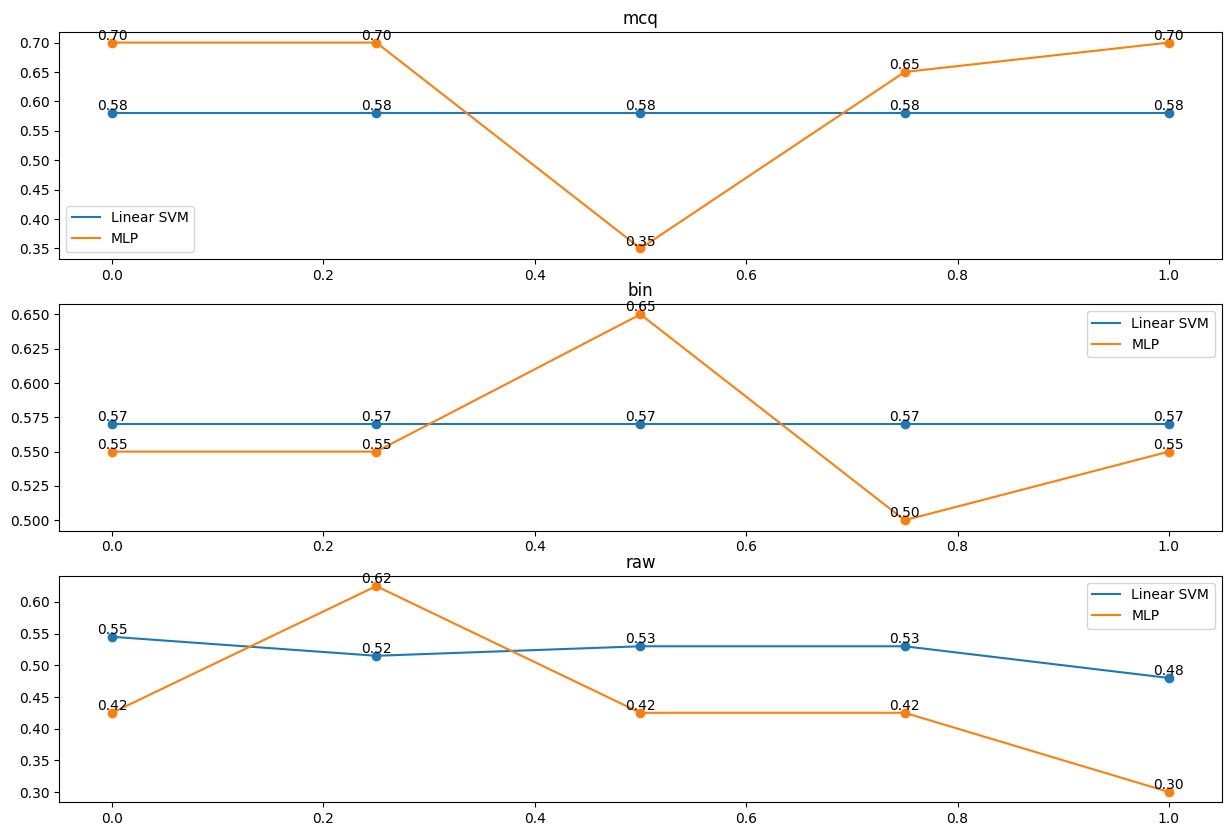

In [12]:
plot_all_layers_separation(numerical_gembeddings)